# Beer Segmenter
## Project Domain and Context
This project wants to propose an alternative solution to a previous project I recently contributed to. The overall project involved developing a robotic bar capable of handling beer orders, filling up to four glasses simultaneously, and serving them.

My task was to create a recognition system to detect the beer level and trigger a signal to stop the dispenser when a glass was filled. (Technically, this task could have been solved without a visual recognition system, as the dispensing pressure was constant and regulated by a dedicated system. However, the designer of the robotic bar seemed to prefer a more challenging approach...)

For this, a camera was positioned next to the beer dispenser, capturing a top-down view of the glass. Due to this positioning, estimating the poured volume was not feasible, as the view was not lateral. Instead, the approach relied on segmenting the foam and stopping the pouring when the segmented area exceeded a predefined threshold.

Fortunately, the liquid pressure ensured a consistent layer of thick foam from start to finish, preventing gaps where the beer’s color might appear. This problem was addressed using a YOLO-based segmenter, fine-tuned to recognize the shape of the beer.

## Image Processing-Based Solution
This notebook presents an image-processing-based solution to the same problem, detailing the complete workflow to achieve a result comparable to the AI-based approach.

In [59]:
from IPython.display import display, HTML

html_code = '''
<div style="display: flex; justify-content: space-between; align-items: flex-start;">
    <div style="text-align: center;">
        <h3>AI solution</h3>
        <video width="100%" controls>
            <source src="assets/ai_result.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
    <div style="text-align: center;">
        <h3>Image processing solution</h3>
        <video width="100%" controls>
            <source src="videos/result.mp4" type="video/mp4">
            Your browser does not support the video tag.
        </video>
    </div>
</div>
'''

display(HTML(html_code))


## Goal
We have a video of a cup being filled with beer. Our goal is to segment the shape of the beer in each frame to estimate the beer level percentage. Below is a raw video that we will use to explain the workflow for achieving the result.

In [60]:
from IPython.display import display, HTML

html_code = '''
<div style="display: block; justify-content: space-between; align-items: flex-start;">
    <h3>Raw video</h3>
    <video width="50%" controls>
        <source src="raw_video.mov" type="video/mp4">
        Your browser does not support the video tag.
    </video>
</div>
'''
display(HTML(html_code))


## Frame preprocessing
Let us start by considering a single frame. At the beginning of the video the foam has not a very sharp contour, moreover thare are some little air boubles that should be removed.

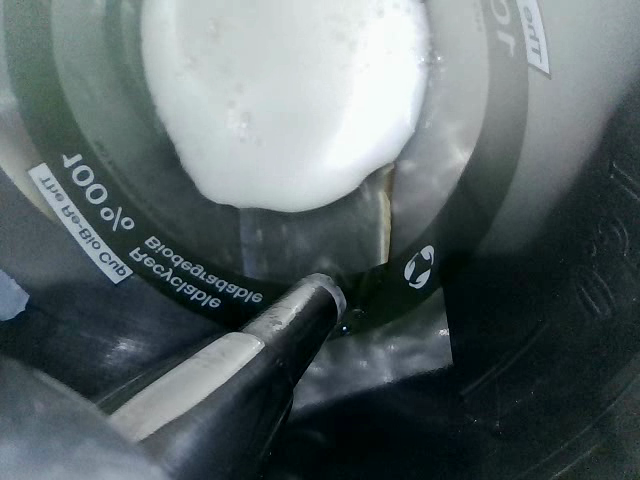

In [61]:
from PIL import Image

frame = Image.open("frames/frame3.png")
display(frame)

I decided to appy the following series of filters:

- **Truncating threshold** to set pixel values above 200 as 200 in order to reduce the intensity of very bright areas like reflections on the foam;
- **Gaussian blur** with a large kernel (13, 13) to remove noise, but more importantly possible bubbles that could make obtain bad contours;
- **Median blur** to attenuate darker points like smaller bubbles particularly in the contours;
- **CLAHE filter**, a filter that enhances local contrast by performing histogram equalization adaptively in small tiles of 4x4 pixels. Boosts contrast in darker areas, making foam structures clearer (filter adopted also for the proprocessing step of the AI solution to ease segmentation);
- **Canny filter** to get a binary image that will be elaborated afeterwads to identify beer contours.

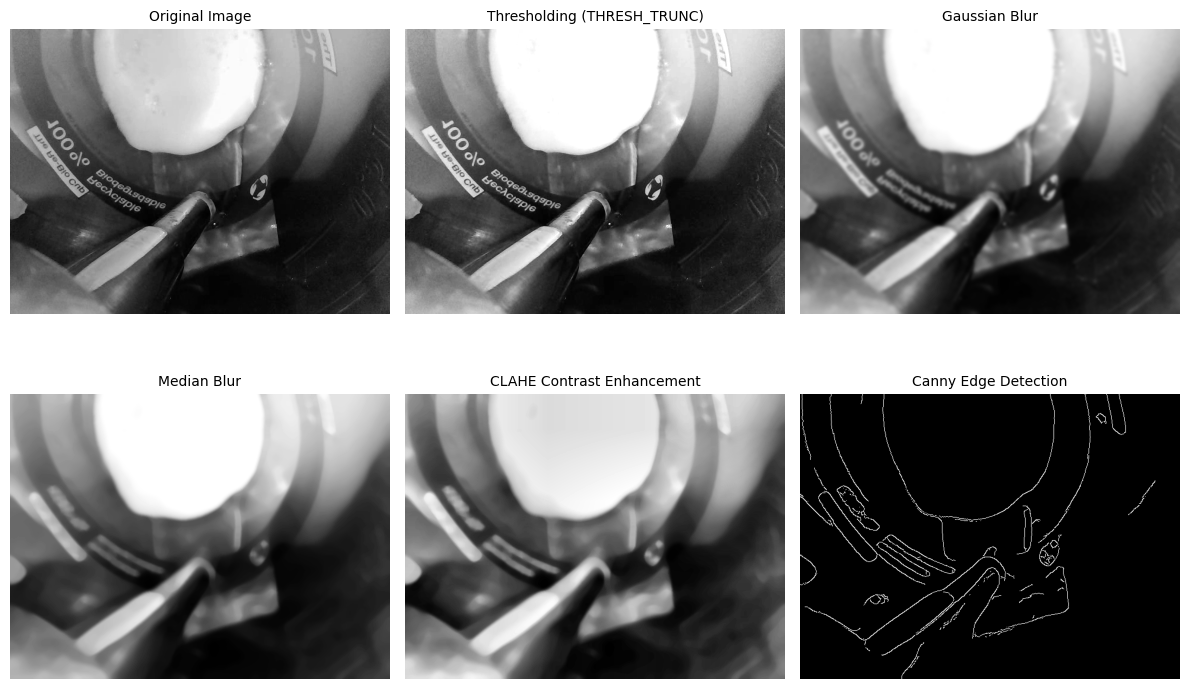

In [62]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Convert PIL image to OpenCV image
img = np.array(frame) # convert to numpy array
frame = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

# Step 1: Apply Truncated Thresholding
_, img_thresh = cv2.threshold(img, 200, 255, cv2.THRESH_TRUNC)

# Step 2: Apply Gaussian Blur
img_gauss = cv2.GaussianBlur(img_thresh, (13, 13), 0)

# Step 3: Apply Median Blur
img_median = cv2.medianBlur(img_gauss, 15)

# Step 4: Apply CLAHE (Contrast Enhancement)
clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(4, 4))
img_clahe = clahe.apply(img_median)

# Step 5: Apply Canny Edge Detection
img_canny = cv2.Canny(img_clahe, threshold1=30, threshold2=80)


# SHOWING STEPS - Create a mosaic grid with labels
titles = ["Original Image", "Thresholding (THRESH_TRUNC)", 
          "Gaussian Blur", "Median Blur", 
          "CLAHE Contrast Enhancement", "Canny Edge Detection"]
images = [img, img_thresh, img_gauss, img_median, img_clahe, img_canny]

# Plot the images in a 2x3 grid
plt.figure(figsize=(12, 8))

for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(images[i], cmap="gray")
    plt.title(titles[i], fontsize=10)
    plt.axis("off")

plt.tight_layout()
plt.show()


Despite we can already see the foam's contour, the lines we obtained are not suitable to get a good segmentation because they are fragmented. We need to perform a **dilate operation** to connect the small gaps between edges obtained by the Canny filter.

`Dilation` is a morphological operation that expands the white (or bright) regions in an image. It is commonly used in noise removal, enhancing object boundaries, and bridging small gaps in segmented images (as in our case).

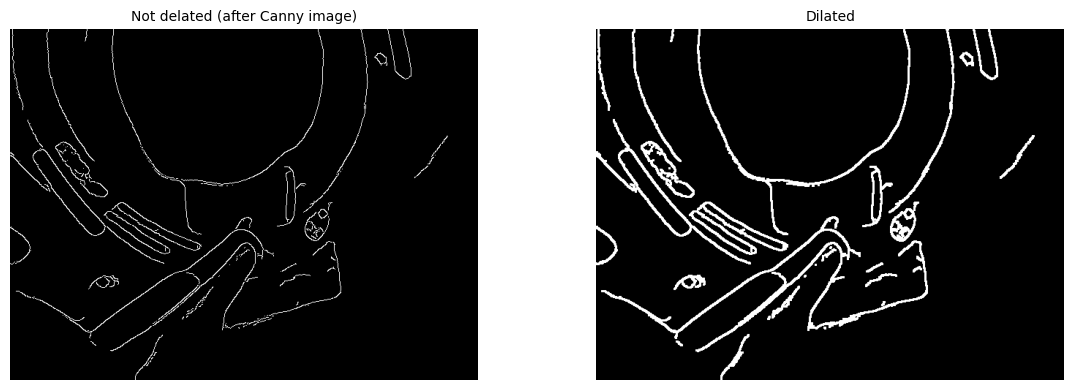

In [63]:

kernel = np.ones((3, 3), np.uint8)
dilated_img = cv2.dilate(img_canny, kernel, iterations=1)

# Create a 1-row, 3-column figure
fig, axes = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 3 columns

# List of images and titles
images = [img_canny, dilated_img]
titles = ["Not delated (after Canny image)", "Dilated"]

# Loop to display images
for i, ax in enumerate(axes):
    ax.imshow(images[i], cmap='gray')
    ax.set_title(titles[i], fontsize=10)
    ax.axis("off")

plt.tight_layout()
plt.show()

As one can see, there are numerous contours in the image, and we need a way to identify the circular-like shape located in the upper part of the frame. I initially attempted to use a Freeman chain code to select contours resembling a circle or an ellipse, but it often selected other elements in the image rather than the foam’s shape—likely because the foam contour is excessively irregular and not a fully closed line.

Among the many contours detected with the Canny filter, our goal is to isolate only the foam’s contour. At first, I tried leveraging the ellipse-like nature of the beer’s contour by estimating ellipses using ```cv2.fitEllipse()``` from the detected shapes. However, since the contour is not closed, the algorithm tended to detect small ellipses along archs of the contour, as shown in the image below. Even setting a threshold on the axes to filter smaller ellipses it was very improbable that the countour of the foam would be used to estimate an ellipses (probably because the conours was noisy due to bubbles).

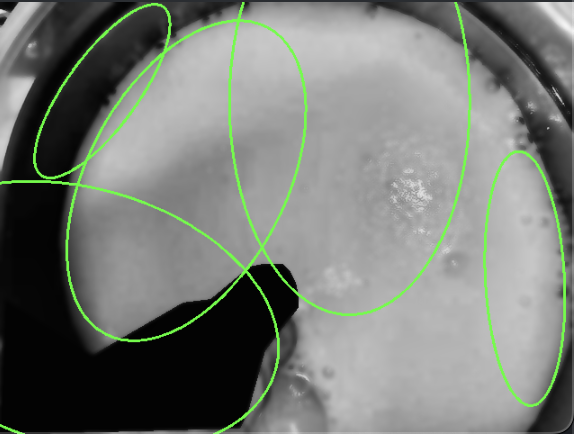

In [64]:
test_image = Image.open('frames/test1.png')
display(test_image)

Thus, I decided to take a different approach by leveraging the problem’s inherent properties. I observed that:

If the foam is properly preprocessed, its contour will be almost or completely absent.
The glass is always in the same initial position, and the robotic arm follows a consistent movement pattern. As a result, the foam shape will expand in a fairly predictable manner. The only exception occurs when the arm straightens the glass, causing a temporary decrease in the foam’s area, as the glass starts in an inclined position.
Based on these observations, the idea is to define a **probable center** that consistently falls near the center of the foam and then select the nearest contours.

## Finding inner contours

I created a function that, given the edges obtained after the preprocessing, searches for the closest edge pixels around a given center by casting rays in multiple directions (default: 360, covering a full circle). The goal is to identify the innermost contour surrounding the center.

In [65]:
def find_inner_contour(edges, center, num_rays=360):
    height, width = edges.shape
    angles = np.linspace(0, 2 * np.pi, num_rays)
    contour_points = []
    
    for angle in angles:
        for r in range(1, min(width, height)):
            x = int(center[0] + r * np.cos(angle))
            y = int(center[1] + r * np.sin(angle))
            
            if 0 <= x < width and 0 <= y < height and edges[y, x] > 0:
                contour_points.append([x, y])
                break
    
    return np.array(contour_points, dtype=np.int32)

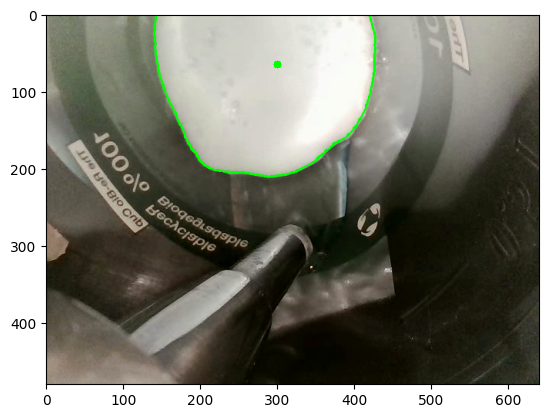

In [66]:
# Find the inner contour of the ellipse
center = (300, 65)
ellipse_contour = find_inner_contour(dilated_img, center=center)

#show
img = frame.copy()
img = cv2.circle(img, center, 5, (0, 255, 0), -1)
img = cv2.drawContours(img, [ellipse_contour], -1, (0, 255, 0), 2)
plt.imshow(img)


## Segmenting larger foam

However, the inner contour method doesn’t perform well when the beer reaches the metal dispensing pipe. Indeed, the pipe becomes a sort of obstacle for the rays traced from the center. Additionally, toward the end of the pouring process, larger bubbles are more likely to form, which can "fool" this approach.

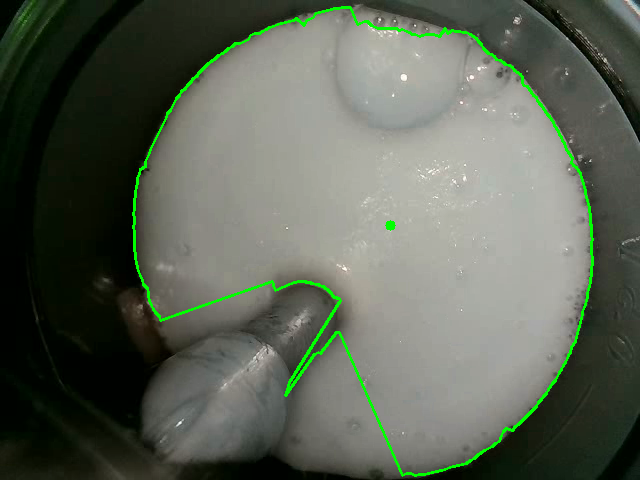

In [67]:
frame = Image.open("frames/frame6.png") # frame with larger foam
center = (390, 225)

def load_and_preprocess_image(frame):
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    _, img = cv2.threshold(img, 200, 255, cv2.THRESH_TRUNC)
    blurred = cv2.GaussianBlur(img, (13, 13), 0)
    blurred = cv2.medianBlur(blurred, 15)
    clahe = cv2.createCLAHE(clipLimit=1.8, tileGridSize=(4, 4))
    blurred = clahe.apply(blurred)
    edges = cv2.Canny(blurred, threshold1=30, threshold2=80)
    return edges

frame = np.array(frame)
edges = load_and_preprocess_image(frame)

dilated = cv2.dilate(edges, kernel, iterations=1)
contours = find_inner_contour(dilated, center)

frame2 = frame.copy()
frame2 = cv2.circle(frame2, center, 5, (0, 255, 0), -2)
frame2 = cv2.drawContours(frame2, [contours], -1, (0, 255, 0), 2)
frame2 = cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)
display(Image.fromarray(frame2))


I observed that the application of k-means is more effective when the area of the foam is quite large.
A method that is more effective is k-means because from the middle of the video on the surface of the beer is larger and the glass becomes a little darker creating 2 clusters. Furthermore, this algorithm permits to obtain more precise borders where color of pixels change markedly, on the other hand the segmentation could be less effective where the foam has shadows or in the points reflexing the white of the foam.

In [68]:
# Applies k-means clustering to segment the image
def segment_image(image, k):
    pixels = image.reshape((-1, 3)).astype(np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 0.8)
    _, labels, centers = cv2.kmeans(pixels, k, None, criteria, 18, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    segmented = centers[labels.flatten()].reshape(image.shape)
    return segmented, labels.reshape(image.shape[:2]), centers


# Find the culster having longest contour of the color specified
def find_largest_cluster_contours(segmented, color):
    mask = cv2.inRange(segmented, color, color)
    contours, _ = cv2.findContours(mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if not contours:  # Se non ci sono contorni, restituisci una lista vuota
        return []

    # Ordina i contorni per area e prendi il più grande
    contours = sorted(contours, key=cv2.contourArea, reverse=True)
    
    return contours[:1]  # Tieni solo il contorno più grande


def find_kmeans_contour(frame, clusters=2):
    original_image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    original_height, original_width = original_image.shape[:2]

    resized_dim = (400, 400)

    resized_image = cv2.resize(original_image, resized_dim)
    segmented_image, labels, centers = segment_image(resized_image, clusters)
    
    centers = sorted(centers, key=lambda x: x[0], reverse=True) # sort lables by color (white, black), because they can be randomly assigned
    
    contours_white = find_largest_cluster_contours(segmented_image, centers[0])
    
    contours = contours_white[0]
    
    scale_x = original_width / resized_dim[0]
    scale_y = original_height / resized_dim[1]
    
    return np.array([[(int(p[0][0] * scale_x), int(p[0][1] * scale_y))] for p in contours])

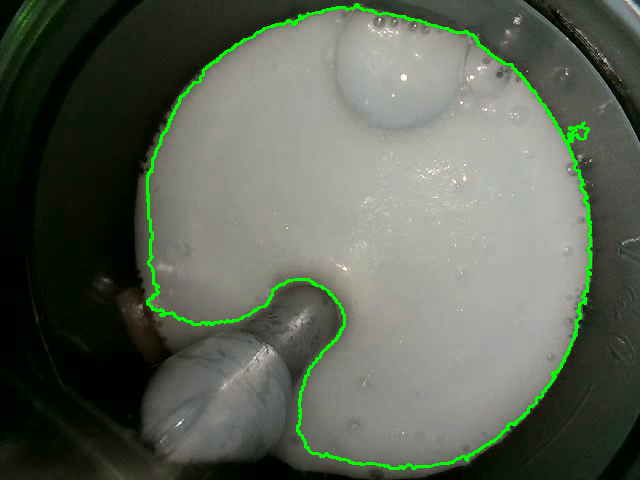

In [69]:
kmeans_contour = find_kmeans_contour(frame)
frame3 = frame.copy()
frame3 = cv2.drawContours(frame, [kmeans_contour], -1, (0, 255, 0), 2)
frame3 = cv2.cvtColor(frame3, cv2.COLOR_BGR2RGB)

display(Image.fromarray(frame3))

I wasn’t able to perfectly segment the foam due to shadows. Tests with three clusters were also conducted, but they generally produced similar results. In such cases, it was necessary to identify the cluster corresponding to the shadowed area. However, in many instances (as seen in the image below), the gray cluster tended to merge the shadowed foam with the right part of the glass into a single cluster. As a result, segmentation using K-means with more than three clusters became difficult to manage.

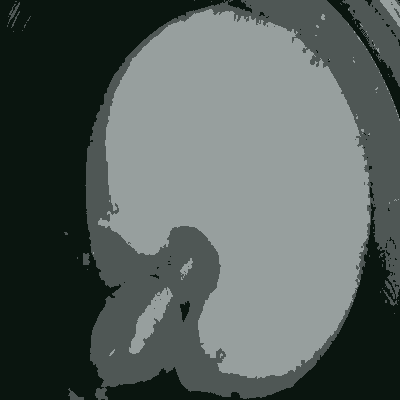

In [70]:
frame = cv2.imread("frames/frame6.png")
frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
resized_image = cv2.resize(frame, (400, 400))
segmented_image, labels, centers = segment_image(resized_image, k=3) # 3 clusters

display(Image.fromarray(segmented_image))    


## Combined method

The idea is to apply first method until the area does not overcome a certain treshold, then apply k-means. I tried to set the threshold when inner contour method is not so effective, but on the same time when the cup is enough filled in ordet to get 2 acceptable cluesters.

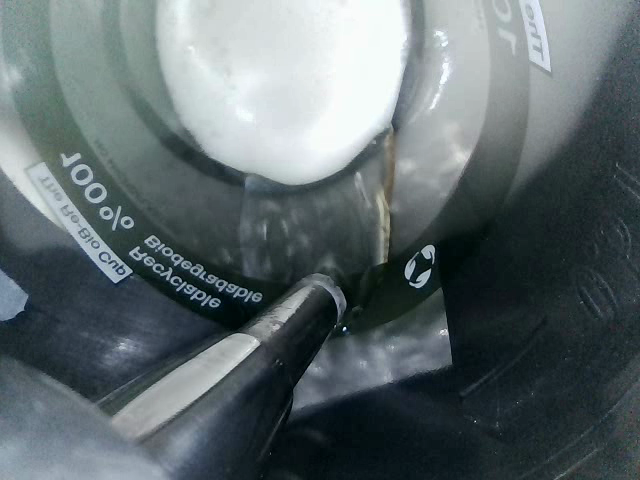

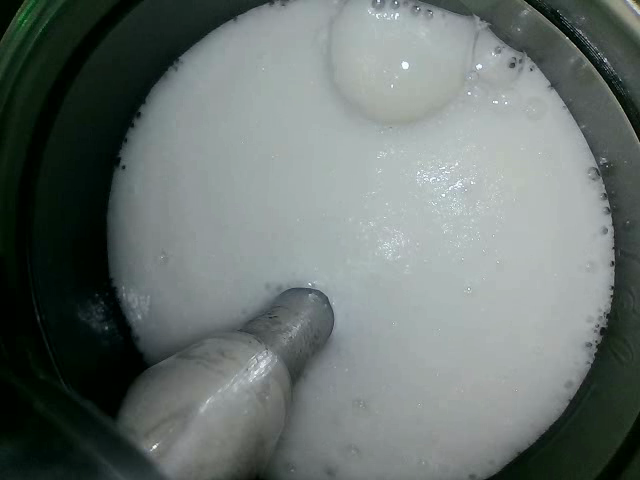

In [71]:
frame1 = cv2.imread("frames/frame2.png")
frame2 = cv2.imread("frames/frame8.png")
display(Image.fromarray(cv2.cvtColor(frame1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(frame2, cv2.COLOR_BGR2RGB)))


Let's define a function to calculate the area of the segmentation and another one to manage the complete workflow to process a single frame. Parameters of **process_frame** *max_area* is used to keep track of maximum area in order to cope with cases in which reflexes in the beer of bubbles could reduce the surface of the contour. However, one could say that there could be the risk that the area instead of decrease it could increase and change too early the segmenation method.
After having tested the code with 10 videos, in the first part of the video, using the first method, I observed no increase of area such to switch the method.

In [72]:
def calculate_contour_area(contour):
    if contour is None:
        return 0
    if len(contour) == 0:
        return 0
    return cv2.contourArea(contour)

use_combined_method = False

def process_frame(frame, center, max_area):
    global use_combined_method
    edges = load_and_preprocess_image(frame)
    
    kernel = np.ones((3, 3), np.uint8)
    edges = cv2.dilate(edges, kernel, iterations=1)
    
    if use_combined_method:
        contour = find_kmeans_contour(frame)
    else:
        contour = find_inner_contour(edges, center)
        
    area = calculate_contour_area(contour)
    output_img = cv2.cvtColor(edges, cv2.COLOR_GRAY2BGR)
    
    if area > max_area:
        max_area = area
    
    if area > 120000 and not use_combined_method:
        use_combined_method = True
    
    if contour is not None:
        cv2.drawContours(output_img, [contour], -1, (0, 0, 255), 2)
        cv2.drawContours(frame, [contour], -1, (0, 0, 255), 2)
        
    else:
        print("Contorno non trovato")
        
    # Mostra l'area calcolata
    cv2.putText(frame, f"Beer level: {max_area/215000*100:.0f}%", (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)
    if not use_combined_method:
        cv2.circle(frame, center, 5, (0, 255, 0), -1)
        cv2.circle(output_img, center, 5, (0, 255, 0), -1)
    
    return frame, max_area

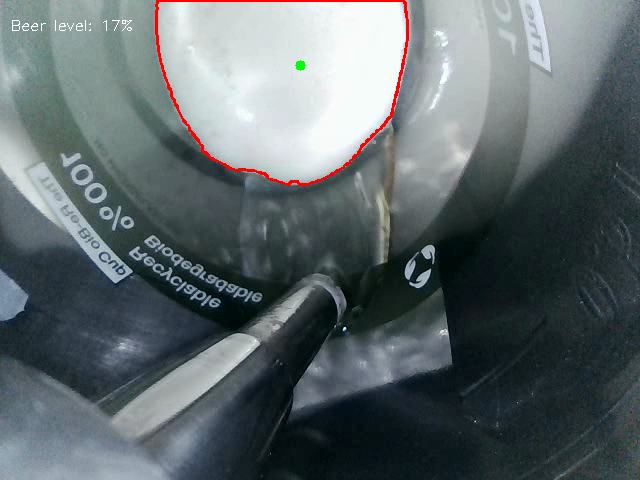

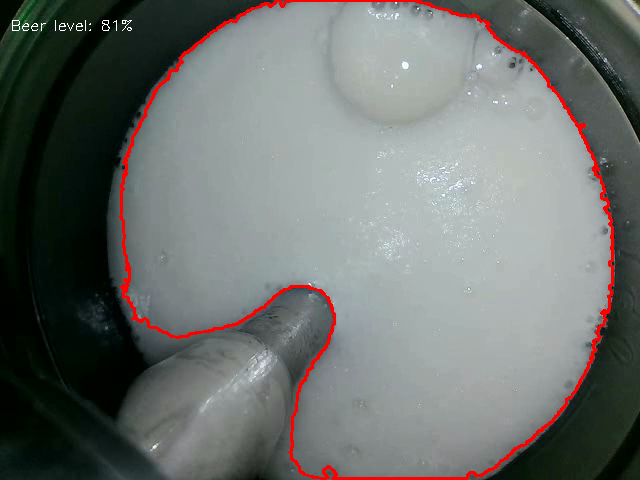

In [73]:
output_frame1, max_area = process_frame(frame1, (300, 65), 0)
use_combined_method = True # Force combined method
output_frame2, max_area = process_frame(frame2, (390, 225), 0)

display(Image.fromarray(cv2.cvtColor(output_frame1, cv2.COLOR_BGR2RGB)))
display(Image.fromarray(cv2.cvtColor(output_frame2, cv2.COLOR_BGR2RGB)))

## Segmenting the video

Now we can extend this procedure to the whole video. I created a function that takes in input video path, initial position of the center to use the "Inner contour" method and the final position of the center.
These two position are then used to create a linear trajectory to move slowly the center.

In [74]:
def move_center_smoothly(initial, final, step, total_steps):
    easing = step / total_steps # linear easing
    new_x = int(initial[0] + (final[0] - initial[0]) * easing)
    new_y = int(initial[1] + (final[1] - initial[1]) * easing)
    return (new_x, new_y)

In [75]:
import os
from tqdm import tqdm

use_combined_method = False

def process_video(video_path, output_path, initial_center, final_center):
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        print("Errore nell'apertura del video")
        return
    
    frame_width = int(cap.get(3))
    frame_height = int(cap.get(4))
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    fourcc = cv2.VideoWriter_fourcc(*'XVID')
    temp_output = "temp.avi"
    out = cv2.VideoWriter(temp_output, fourcc, fps, (frame_width, frame_height))
    
    prev_contour = None
    max_area = 0  # Inizializza l'area massima
    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    
    for step in tqdm(range(frame_count), desc="Processing video", unit="frame"):
        ret, frame = cap.read()
        if not ret:
            break
        
        center = move_center_smoothly(initial_center, final_center, step, frame_count*0.9)
        processed_frame, max_area = process_frame(frame, center, max_area)
        out.write(processed_frame)
    
    cap.release()
    out.release()
    
    os.system(f"ffmpeg -i temp.avi -vcodec libx264 {output_path}")
    os.remove("temp.avi")
    print("Processing complete. video saved in:", output_path)


video_path = "videos/5.mp4"
output_path = "videos/result2.mp4"
initial_center = (300, 65)
final_center = (386, 279)

os.remove(output_path) if os.path.exists(output_path) else None # Remove the output file if it already exists, otherwise you will need to manually delete it
process_video(video_path, output_path, initial_center, final_center)

Processing video:  98%|█████████▊| 295/301 [00:52<00:01,  5.57frame/s]
ffmpeg version 6.0 Copyright (c) 2000-2023 the FFmpeg developers
  built with Apple clang version 15.0.0 (clang-1500.0.40.1)
  configuration: --prefix=/opt/homebrew/Cellar/ffmpeg/6.0_1 --enable-shared --enable-pthreads --enable-version3 --cc=clang --host-cflags= --host-ldflags='-Wl,-ld_classic' --enable-ffplay --enable-gnutls --enable-gpl --enable-libaom --enable-libaribb24 --enable-libbluray --enable-libdav1d --enable-libjxl --enable-libmp3lame --enable-libopus --enable-librav1e --enable-librist --enable-librubberband --enable-libsnappy --enable-libsrt --enable-libsvtav1 --enable-libtesseract --enable-libtheora --enable-libvidstab --enable-libvmaf --enable-libvorbis --enable-libvpx --enable-libwebp --enable-libx264 --enable-libx265 --enable-libxml2 --enable-libxvid --enable-lzma --enable-libfontconfig --enable-libfreetype --enable-frei0r --enable-libass --enable-libopencore-amrnb --enable-libopencore-amrwb --enable

Processing complete. video saved in: videos/result2.mp4


frame=  295 fps=207 q=-1.0 Lsize=    2303kB time=00:00:19.46 bitrate= 969.2kbits/s speed=13.6x    
video:2299kB audio:0kB subtitle:0kB other streams:0kB global headers:0kB muxing overhead: 0.161858%
[libx264 @ 0x12bf05800] frame I:2     Avg QP:20.00  size: 23679
[libx264 @ 0x12bf05800] frame P:162   Avg QP:21.60  size: 10012
[libx264 @ 0x12bf05800] frame B:131   Avg QP:24.26  size:  5226
[libx264 @ 0x12bf05800] consecutive B-frames: 35.9% 10.2% 13.2% 40.7%
[libx264 @ 0x12bf05800] mb I  I16..4: 11.9% 80.9%  7.2%
[libx264 @ 0x12bf05800] mb P  I16..4:  2.6% 13.8%  0.4%  P16..4: 50.7% 13.2%  8.1%  0.0%  0.0%    skip:11.2%
[libx264 @ 0x12bf05800] mb B  I16..4:  0.8%  7.3%  0.1%  B16..8: 48.6%  6.2%  1.6%  direct: 3.9%  skip:31.5%  L0:56.8% L1:34.5% BI: 8.8%
[libx264 @ 0x12bf05800] 8x8 transform intra:83.8% inter:78.8%
[libx264 @ 0x12bf05800] coded y,uvDC,uvAC intra: 61.9% 50.4% 4.4% inter: 23.6% 20.3% 8.8%
[libx264 @ 0x12bf05800] i16 v,h,dc,p: 25% 23% 30% 23%
[libx264 @ 0x12bf05800] i8 v,h,

In [76]:
html_code = '''
<div style="display: block; justify-content: space-between; align-items: flex-start;">
    <h3>Processed video</h3>
    <video width="50%" controls>
        <source src="videos/result2.mp4" type="video/mp4">
        Your browser does not support the video tag.
    </video>
</div>
'''

display(HTML(html_code))

## Limitations and possible upgrades

As one can see in the resulting video, while in the first part the segmentation is quite smooth, the second using kmeans has some problems with the reflexes on the top-right of the cup. It has been tried to apply a threshold to reduce bright pixels but if done too much the segmentation was worse. Probably, there could be some combination or a filter it hasn't been tried that could deal with it.

A possible add-on could be an algorithm to "remember" previous contours and manage cases in which bubbles or reflexes could change suddlenly for few frames the shape of the segmentation.
Theoretically, another way to obtain a similar result without could be to use algorithm to estimate motion of the foam like Optical Flow (e.g. Lucas-Kanade using feature points to estimate motion or Farneback by examining pixel change frame by frame).

## Comparison with AI

Traditional image processing techniques, like the Canny filter and K-means clustering, rely on manually defined rules and thresholds, making them effective for well-structured and consistent images but less adaptable to variations in lighting, foam texture, and background noise. In contrast, the AI-based YOLO solution is more flexible and robust, as it learns from a dataset and generalizes better across different conditions. While traditional methods can work well for simple cases, AI provides a more scalable and accurate approach, especially when dealing with complex or inconsistent foam patterns.